In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import plotsettings
from optparse import OptionParser
from matplotlib import rc
mpl.rc('text.latex', preamble = '\usepackage{txfonts}')
import bayesian as ba
import imrtestgr as tgr
import scipy
from scipy import interpolate
import read_emcee_samples as res

rc_params = {'backend': 'ps',
             'axes.labelsize': 10,
             'axes.titlesize': 10,
             'font.size': 12,
             'legend.fontsize': 12,
             'xtick.labelsize': 13,
             'ytick.labelsize': 13,
             'font.family': 'Times New Roman',
             'font.family': 'sans-serif',
             'font.sans-serif': ['Bitstream Vera Sans']
             }

## Confidence modules

In [2]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# compute 1-sigma confidence intervals in 1D 
def calc_cred_intervals_in_1d(P, x):

    # find the value of P corresponding to 50% and 9% confidence heights 
    conf = confidence(P)
    P_s1 = conf.height_from_level(0.5)
    P_s2 = conf.height_from_level(0.9)

    # calculation of condifence edges (values of x corresponding to the height s1 on the two sides) 
    x_s1_l = min(x[np.where(P >= P_s1)[0]])
    x_s1_r = max(x[np.where(P >= P_s1)[0]])

    # calculation of condifence edges (values of x corresponding to the height s2 on the two sides) 
    x_s2_l = min(x[np.where(P >= P_s2)[0]])
    x_s2_r = max(x[np.where(P >= P_s2)[0]])

    return P_s1, P_s2, x_s1_l, x_s1_r, x_s2_l, x_s2_r

## Location of runs

In [3]:
post_loc_bbh = '/home/ajit.mehta/gr_consistency_highermodes/runs/modGR_simulations/SNR50/BBH_M120_iota1.57/emcee_samples.dat'
post_loc_nsbh = '/home/ajit.mehta/gr_consistency_highermodes/runs/modGR_simulations/SNR50/NSBH_M120_iota1.57/emcee_samples.dat'

post_loc_list = [post_loc_bbh, post_loc_nsbh]
color = ['c','k']
label=['BBH', 'NSBH']

## Plotting (dMc, dq) plots

Credible level of the GR value (BBH): 32.93% 


/home/abhirup/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


Credible level of the GR value (NSBH): 99.34% 


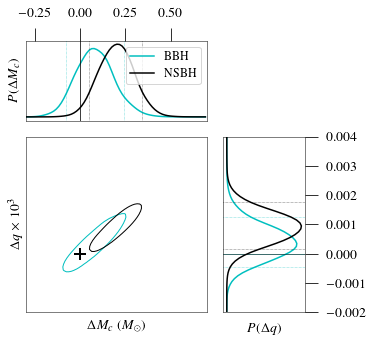

In [7]:
Nbins = 101
nwalkers, num_iter, ndim, n_burnin = 200, 20000, 11, 15000

p = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2)
ax3 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)

for (idx, post_loc) in enumerate(post_loc_list):
    mc, q, mc1, q1, dL, i, t0, phi0, ra, sin_dec, pol = res.read_emcee_samples_11dim(post_loc, nwalkers, num_iter, ndim, n_burnin)
    dmc_2d, dq_2d = mc - mc1, q - q1
    
    dmc_bins = np.linspace(-0.7, 0.7, Nbins)
    dq_bins = np.linspace(-0.005, 0.005, Nbins)
    dmc = np.mean(np.diff(dmc_bins))
    dq = np.mean(np.diff(dq_bins))

    dmc_intp = (dmc_bins[:-1] + dmc_bins[1:])/2.
    dq_intp = (dq_bins[:-1] + dq_bins[1:])/2.

    P_dmc_dq_2d, dmc_bins, dq_bins = np.histogram2d(dmc_2d, dq_2d, bins=(dmc_bins, dq_bins), normed=True)
    P_dmc_dq_2d = P_dmc_dq_2d.T
    P_dmc_marg = np.sum(P_dmc_dq_2d, axis=0) * dq
    P_dq_marg = np.sum(P_dmc_dq_2d, axis=1) * dmc
    
    # computing 50 and 90% credible levels for 2d distribution
    conf_s1s2 = confidence(P_dmc_dq_2d)
    s1_2d = conf_s1s2.height_from_level(0.5)
    s2_2d = conf_s1s2.height_from_level(0.9)
    
    # computing credible level for GR predition of (0,0)
    
    gr_height = P_dmc_dq_2d[np.argmin(abs(dmc_intp)), np.argmin(abs(dq_intp))]
    gr_credib_level = conf_s1s2.level_from_height(gr_height)
    print 'Credible level of the GR value (%s): %.2f%% '%(label[idx], 100.*gr_credib_level)
    
    # computing 50 and 90% confidence intervals on marginalised 1D distributions
    s1_marg_v1, s2_marg_v1, left1_marg_v1, right1_marg_v1, left2_marg_v1, right2_marg_v1 = calc_cred_intervals_in_1d(P_dmc_marg, dmc_intp)
    s1_marg_v2, s2_marg_v2, left1_marg_v2, right1_marg_v2, left2_marg_v2, right2_marg_v2 = calc_cred_intervals_in_1d(P_dq_marg, dq_intp)
    
    # plotting
    ax1.plot(dmc_intp, tgr.gf(P_dmc_marg),color=color[idx], lw=1.5, label=label[idx])
    ax1.axvline(0.,color='k', ls='-', lw=0.5)
    ax1.axvline(x=left2_marg_v1, color=color[idx], ls=':', lw=0.5)
    ax1.axvline(x=right2_marg_v1, color=color[idx], ls=':', lw=0.5)
    ax1.set_ylabel('$P(\Delta M_c)$',fontsize=14)
    ax1.set_xlim(-0.3, 0.7)
    ax1.xaxis.tick_top()
    ax1.set_yticks([])
    ax1.legend(loc='best')

    ax3.contour(dmc_intp, dq_intp, tgr.gf(P_dmc_dq_2d), levels=(s2_2d,), linewidths=(1,1.5), colors=color[idx])
    ax3.plot(0, 0, '+', color='k', ms=12, mew=2)
    ax3.set_xlabel('$\Delta M_c ~ (M_\odot)$',fontsize=14, labelpad=10)
    ax3.set_ylabel('$\Delta q \, \\times \, 10^{3}$',fontsize=14)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_xlim(-0.3, 0.7)
    ax3.set_ylim(-0.002, 0.004)
    
    ax2.plot(tgr.gf(P_dq_marg), dq_intp,color=color[idx], lw=1.5)
    ax2.axhline(0.,color=color[idx], ls='-', lw=0.5)
    ax2.axhline(y=left2_marg_v2, color=color[idx], ls=':', lw=0.5)
    ax2.axhline(y=right2_marg_v2, color=color[idx], ls=':', lw=0.5)
    ax2.set_xlabel('$P(\Delta q)$',fontsize=14, labelpad=10)
    ax2.set_xticks([])
    ax2.set_ylim(-0.002, 0.004)
    ax2.yaxis.tick_right()
    
    plt.hold(True)
    
plt.show()    
    